## **Bayesian Optimization**

Using `twinLab`, we can easily build a surrogate model of some real-world physical processes using limited experimental data. The discrepancy between this surrogate model and the real process is described by the (calibrated) uncertainty estimate produced our models. This way, inference activities while using the surrogate model can be supported by well-grounded evidence of the model *correctness*. In areas of high model uncertainty, one must then take care to not be overly trusting of the model output, which is especially important for safety-critical applications.

In some scenarios, there may be a requirement to find the value that maximizes an objective function(that is not available but we know this function generated the data points in our training data). `twinLab` offers the feature of finding the maximising values for a given function. This can be done once the model is fitted to the training data. The acquisition function `qEI` (Monte Carlo Expected Improvement) is used to find the value that maximizes an objective function using the Gaussian process trained on training data using `twinLab`. 

This notebook will cover:
- Finding the maxima of a function using `twinLab` 

In [1]:
# Third party imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# twinLab import
import twinlab as tl

### **1-Dimensional example**

We first begin with a one-dimensional example. Consider the following function:

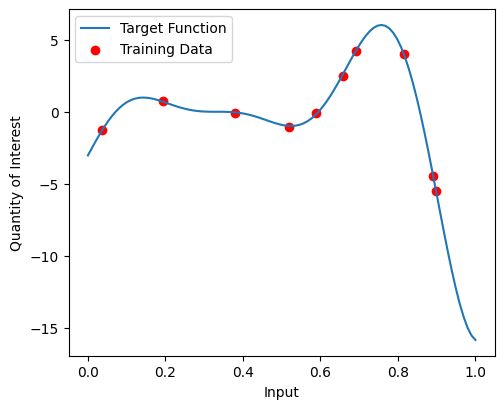

In [140]:
seed = 20
np.random.seed(seed)
# Target function: forrester function
def f(x, a=6, b=12):
    return -(a*x - 2)**2 * np.sin(b*x -4)

X = np.linspace(0,1,100)[:,np.newaxis]
y = f(X) # Arrange outputs as feature columns

# Set up training data dataframe 
n_train = 10
X_data = np.random.uniform(0, 1, size=n_train)
y_data = f(X_data) + np.random.normal(scale=0.1, size=X_data.shape)

# Plot
plt.figure(figsize=(5.5, 4.5))
plt.plot(X,y, label="Target Function")
plt.scatter(X_data, y_data, color="red", label="Training Data")
plt.xlabel("Input")
plt.ylabel("Quantity of Interest")
plt.legend()
plt.show()

Create the dataset and upload it to the twinLab cloud

In [141]:
# Convert to DataFrame
df_train = pd.DataFrame({'X': X_data, 'y': y_data})
df_test = pd.DataFrame({'X': X.flatten(), 'y': y.flatten()})

# Define the name of the dataset
dataset_id = "Training_Data"

# Upload the dataset to the cloud
tl.upload_dataset(df_train, dataset_id, verbose=True)

Dataframe is uploading.
Processing dataset.
Dataset Training_Data was processed.


Initialise a training campaign to train the model and make predictions on test samples

In [142]:
# Initialise campaign
campaign_id = "BasicGP"

campaign_params = {
    "dataset_id": dataset_id,                   
    "inputs": ["X"],                          
    "outputs": ["y"],
}                                        

# Start a new campaign and train a surrogate model
tl.train_campaign(campaign_params, campaign_id, verbose=True)

# Plot inference results
df_mean, df_stdev = tl.predict_campaign(df_test, campaign_id)
y_mean, y_stdev = df_mean.values, df_stdev.values

Model BasicGP has begun training.


Plot the model's mean prediction and the model's confidence interval around the given data points to visualise how closely the model represents the target function that generated the data points

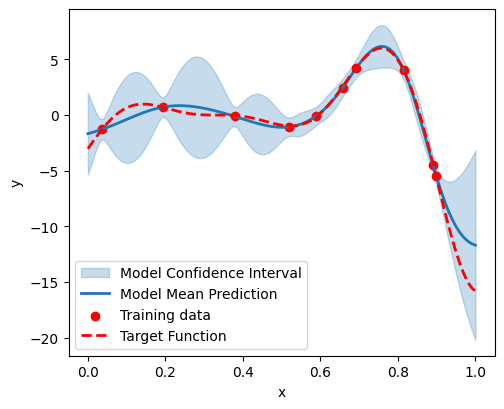

In [143]:
plt.figure(figsize=(5.5, 4.5))
plt.fill_between(X.flatten(), 
                 (y_mean - 2.58*y_stdev).flatten(), 
                 (y_mean + 2.58*y_stdev).flatten(), 
                 color='C0', alpha=0.25, label="Model Confidence Interval")
plt.plot(X, y_mean, c='C0', linewidth=2, label="Model Mean Prediction")

plt.scatter(df_train['X'], df_train['y'], color="red", label="Training data")
plt.xlabel('x'); plt.ylabel('y')

plt.plot(X, y, c='r', linewidth=2, linestyle='dashed', label="Target Function")
plt.legend()
plt.show()

Now, we have an initial model with which we can try to sample a datapoint that the model thinks is the maxima of the objective function with its current knowledge of the hidden function(that we know in this case!). This is done by the `optimise_campaign` function in twinLab

In [144]:
df_max = tl.optimise_campaign("BasicGP", num_points=1)
df_max['y'] = f(df_max['X'].values) + np.random.normal(scale=0.1, size=1)
print(df_max)

          X         y
0  0.758834  6.014973


Plot the model's mean prediction, confidence interval, the training data and the maxima candidate for the target function that was generated by `optimise_campaign`. 
It can bee seen that the point sampled by this function is a maxima of the target function

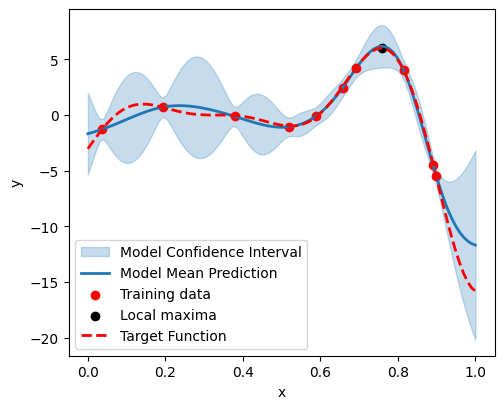

In [145]:
plt.figure(figsize=(5.5, 4.5))
plt.fill_between(X.flatten(), 
                 (y_mean - 2.58*y_stdev).flatten(), 
                 (y_mean + 2.58*y_stdev).flatten(), 
                 color='C0', alpha=0.25, label="Model Confidence Interval")
plt.plot(X, y_mean, c='C0', linewidth=2, label="Model Mean Prediction")

plt.scatter(df_train['X'], df_train['y'], color="red", label="Training data")
plt.scatter(df_max['X'], df_max['y'], color="black", label="Local maxima")
plt.xlabel('x'); plt.ylabel('y')

plt.plot(X, y, c='r', linewidth=2, linestyle='dashed', label="Target Function")
plt.legend()
plt.show()

In [ ]:
# Delete the campaign and dataset
tl.delete_campaign("BasicGP")
tl.delete_dataset("Training_Data")

### **2-Dimensional Example**

In the previous one-dimensional example, the model sampled a point that was a maxima of the target function. This is a very good educated guess for a maxima that the model is making given the very small number of training data points. We can now also see how this works for a 2D example.  

In [150]:
# Define a non-linear, 2D function
def target_function(x, y):
    # Branin function
    a = 1
    b = 5.1 / (4 * np.pi ** 2)
    c = 5 / np.pi
    r = 6
    s = 10
    t = 1 / (8 * np.pi)
    return (
        -(a * (y - b * x ** 2 + c * x - r) ** 2
        + s * (1 - t) * np.cos(x)
        + s)
    )


# Plotting function
def plot_function(
    xx, yy, zz,  # Background grid
    zz_pred=None, zz_stdv=None, # Mean and uncertainty in model function
    x_org=None, y_org=None, z_org=None,  # Original training data
    x_max=None, y_max=None,  # Proposed candidate points for maxima
    show_truth=True,  # Show true function
    ):

    cmap_fn, cmap_std = 'YlGn', 'Blues'
    alpha_fn, alpha_std = 0.8, 1.
    levels = 20
    color_org, color_max = 'black', 'red'
    marker_org, marker_max = 'x', 'o'
    marker_col = 'o'
    vmin, vmax = zz.min(), zz.max()
    figx, figy = 4, 4

    # Set layout
    if zz_pred is None and zz_stdv is None:
        rows, cols = 1, 1
    else:
        rows, cols = 1, 3
    _, axs = plt.subplots(rows, cols, figsize=(cols*figx, rows*figy))

    if rows == 1 and cols == 1:
        axs = np.array([axs])
    axs = np.atleast_2d(axs)
    for ax in axs.flatten():
        ax.set_xticks([]), ax.set_yticks([])
        ax.set_aspect('equal')

    # Plot true function
    if show_truth:
        axs[0, 0].set_title('True function')
        axs[0, 0].contourf(xx, yy, zz, cmap=cmap_fn, levels=levels, alpha=alpha_fn, vmin=vmin, vmax=vmax)
    else:
        axs[0, 0].set_title('True function (unknown)')
        axs[0, 0].set_facecolor('lightgrey')
    
    if x_org is not None and y_org is not None and z_org is not None: # Plot original points
        if show_truth:
            axs[0, 0].scatter(x_org, y_org, c=color_org, marker=marker_org, label='Original samples')
            axs[0, 1].scatter(x_org, y_org, c=color_org, marker=marker_org, label='Original samples')
            axs[0, 2].scatter(x_org, y_org, c=color_org, marker=marker_org, label='Original samples')
        else:
            pass
            axs[0, 0].scatter(x_org, y_org, c=z_org, marker=marker_col, cmap=cmap_fn, vmin=vmin, vmax=vmax, label='Original samples')
        axs[0, 0].legend(loc="upper left")

    # Plot mean prediction
    if zz_pred is not None and zz_stdv is not None:
        axs[0, 1].set_title('Model function')
        axs[0, 1].contourf(xx, yy, zz_pred, cmap=cmap_fn, levels=levels, alpha=alpha_fn, vmin=vmin, vmax=vmax)
        axs[0, 2].set_title('Model uncertainty')
        axs[0, 2].contourf(xx, yy, zz_stdv, cmap=cmap_std, levels=levels, alpha=alpha_std)
        if x_org is not None: # Plot original points
            axs[0, 1].scatter(x_org, y_org, c=color_org, marker=marker_org)
            axs[0, 2].scatter(x_org, y_org, c=color_org, marker=marker_org)
            if rows == 2:
                axs[1, 1].scatter(x_org, y_org, c=color_org, marker=marker_org)
                axs[1, 2].scatter(x_org, y_org, c=color_org, marker=marker_org)
        if x_max is not None: # Plot candidate points for maxima
            axs[0, 0].scatter(x_max, y_max, c=color_max, marker=marker_max, label='Maxima candidate')
            axs[0, 1].scatter(x_max, y_max, c=color_max, marker=marker_max, label='Maxima candidate')
            axs[0, 2].scatter(x_max, y_max, c=color_max, marker=marker_max, label='Maxima candidate')
            axs[0, 0].legend(loc="upper left")
            axs[0, 1].legend(loc="upper left")
            axs[0, 2].legend(loc="upper left")
            if rows == 2:
                axs[1, 2].scatter(x_max, y_max, c=color_max, marker=marker_max)
    
    plt.tight_layout()
    plt.show()

Visualise the 2D target function

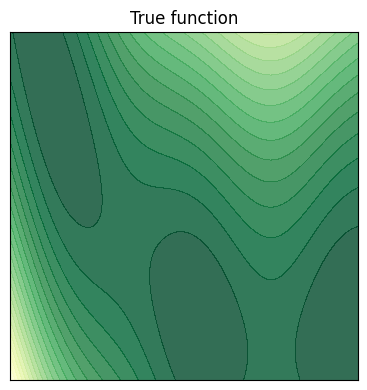

In [151]:
# Seed the random-number generator
seed = 5
np.random.seed(seed)
nmesh = 101
xmin, xmax = -5, 10
ymin, ymax = 0, 15

# Generate a grid of points and evaluate the function at each point
x, y = np.linspace(xmin, xmax, nmesh), np.linspace(ymin, ymax, nmesh)
xx, yy = np.meshgrid(x, y)
zz = target_function(xx, yy)

# Generate noisy train data
n_train = 10
err = 0.1
x_train = np.random.uniform(xmin, xmax, n_train)
y_train = np.random.uniform(ymin, ymax, n_train)
z_train = np.random.normal(target_function(x_train, y_train), err, n_train)

# Number of new data points to generate each iteration
num_points = 1

# Plot the data points
plot_function(xx, yy, zz, x_org=x_train, y_org=y_train)

# Convert to dataframes
df_train = pd.DataFrame({'x': x_train.flatten(), 'y': y_train.flatten(), 'z': z_train.flatten()})
df_test = pd.DataFrame({'x': xx.flatten(), 'y': yy.flatten(), 'z': zz.flatten()})

Upload the training dataset

In [152]:
# Define the name of the dataset
dataset_id = "2DActive_Data"

# Upload the dataset to the cloud
tl.upload_dataset(df_train, dataset_id, verbose=True)

Dataframe is uploading.
Processing dataset.
Dataset 2DActive_Data was processed.


Initialise a training campaign, train the model and predict on the test data

In [153]:
# Initialise campaign
campaign_id = "2DActiveGP"

campaign_params = {
    "dataset_id": dataset_id,                  
    "inputs": ['x','y'],                        
    "outputs": ['z'],
}                                        

# Start a new campaign and train a surrogate model
tl.train_campaign(campaign_params, campaign_id, verbose=True)

# Plot inference results
df_mean, df_stdev = tl.predict_campaign(df_test, campaign_id)
y_mean, y_stdev = df_mean.values, df_stdev.values

Model 2DActiveGP has begun training.


In [154]:
max_candidates = tl.optimise_campaign(campaign_id, num_points=num_points).values
x_max, y_max = max_candidates[:, 0], max_candidates[:, 1]
print(x_max, y_max)

[7.0305222] [1.21111903]


Use a helper function to sample the candidate point and plot the 2D visualizations of the target function, the model's estimation of the target function and the uncertainty map of the model in the 2D space along with the training data points and the candidate point for a local maxima of the target function

In [155]:
def optimise_function(campaign_id, df_train, df_test, n_candidates, df_new=None, show_truth=True):

    # Plot inference results
    df_mean, df_stdev = tl.predict_campaign(df_test, campaign_id)
    z_mean, z_stdv = df_mean.values, df_stdev.values

    x_org, y_org, z_org = df_train['x'].values, df_train['y'].values, df_train['z'].values

    # Get candidate points for maxima of the true function
    max_candidates = tl.optimise_campaign(campaign_id, num_points=n_candidates).values
    x_max, y_max = max_candidates[:, 0], max_candidates[:, 1]

    # Plot sample location
    plot_function(xx, yy, zz, 
                  z_mean.reshape((nmesh, nmesh)), z_stdv.reshape((nmesh, nmesh)),
                  x_org=x_org, y_org=y_org, z_org=z_org,
                  x_max=x_max, y_max=y_max,
                  show_truth=show_truth,
                  )

We now try to visualise the point sampled by the `optimise_campaign` function in twinLab alongside the original training samples on 2D contours. It can be seen that the sampled candidate point is very close to a local maxima of the target function

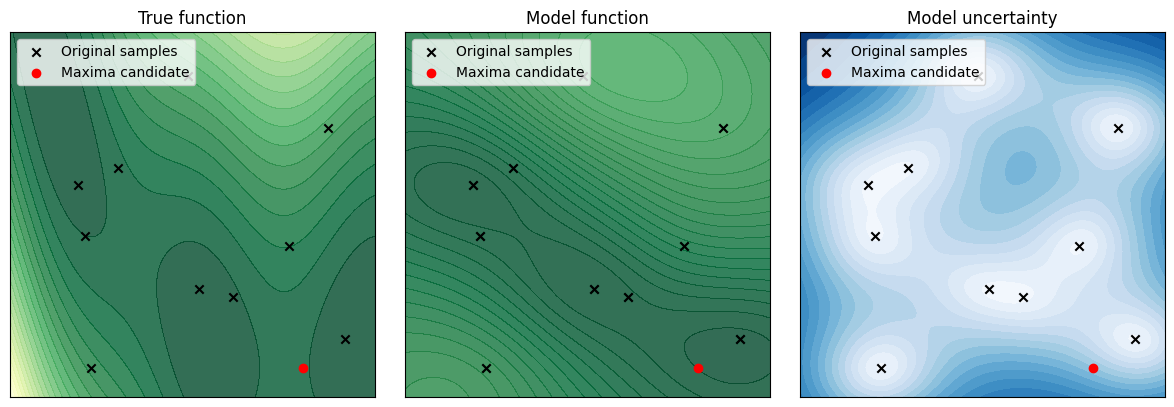

In [156]:
optimise_function("2DActiveGP", df_train, df_test, 1)

In [ ]:
# Delete campaign and dataset
tl.delete_campaign(campaign_id)
tl.delete_dataset("2DActive_Data")
tl.delete_dataset("Training_Data")
tl.delete_dataset("New_Points")